In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import copy
import pprint as pp
import collections, operator

In [3]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from sklearn.neighbors.nca import NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn import model_selection
from sklearn.model_selection import KFold
import xgboost as xgb
import random
# from imblearn.over_sampling import SMOTE
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter
import operator, itertools 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Harsh: Use Python[pytorch] kernel <others, please ignore this line>

### Considering on dummy data 

In [4]:
# Input data : 
# X = num_edges x num_methods, 
# y = predictions (I - 0/1 values; II - 0/1/2/3 hop connections)

E = 10000 # number of edges
M = 6 # number of methods
X = np.random.rand(E, M)
y = np.random.choice([0, 1], size=E, p=[.9, .1]) # percentage labels

## Visualizing the data
Sometimes it can be helpful, so why not!

In [5]:
def visual2D(X, color):
    Axes3D
    n_points = len(color)
    S = 30 # point size for figures

    n_neighbors = 10
    n_components = 2

    # fig = plt.figure(figsize=(15, 8))
    fig = plt.figure(figsize=(20, 8))
    plt.suptitle("2D projection with %i points, %i neighbors"
                 % (n_points, n_neighbors), fontsize=14)

    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='dense',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
        plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("Isomap (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("MDS (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("SpectralEmbedding: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=5)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("t-SNE (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

standard: 0.052 sec
ltsa: 0.082 sec
hessian: 0.13 sec
modified: 0.097 sec
Isomap: 0.18 sec
MDS: 0.5 sec
SpectralEmbedding: 0.032 sec
t-SNE: 2.2 sec


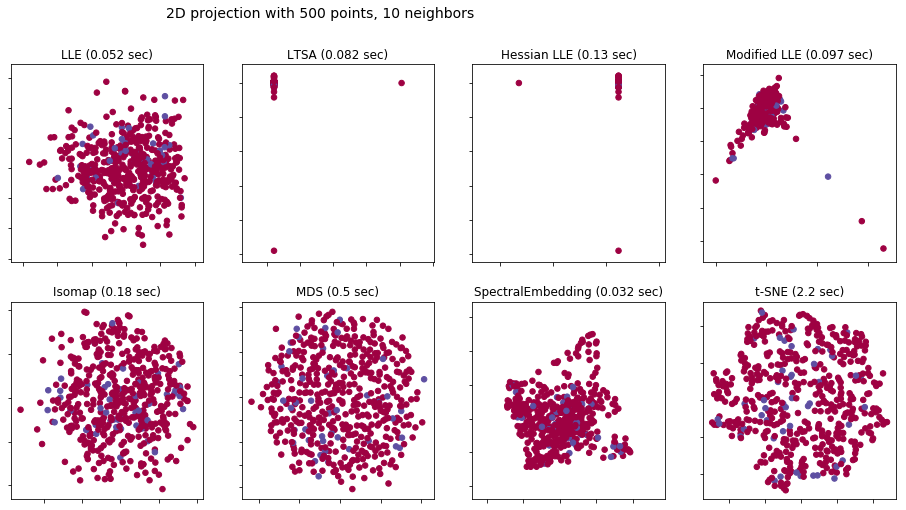

In [6]:
# randomly choose points for visualization
vizPts = 500
visual2D(X[:vizPts, :], y[:vizPts])

## Binary Classification using basic NN

### Basic NN model

In [7]:
# defining the model class
class DNN_model(torch.nn.Module): # 
    def __init__(self, nF, H, USE_CUDA=False): # initializing all the weights here
        super(DNN_model, self).__init__() # initializing the nn.module
        self.USE_CUDA = USE_CUDA
        if USE_CUDA == False:
            self.dtype = torch.FloatTensor
        else: # shift to GPU
            print('shifting to cuda')
            self.dtype = torch.cuda.FloatTensor
            
        self.nF = nF # number of input features 
        self.H = H # hidden layer size
        
        self.DNN = self.fDNN()

    def fDNN(self):
        l1 = nn.Linear(self.nF, self.H).type(self.dtype)
        lH1 = nn.Linear(self.H, self.H).type(self.dtype)
        lF = nn.Linear(self.H, 1).type(self.dtype)
        return nn.Sequential(l1, nn.ReLU(),
                             lH1, nn.ReLU(),
                            lF).type(self.dtype)
                              #l2, nn.Sigmoid()).type(self.dtype)

    def forward(self, X): # model forward
        out = self.DNN(X)
        return out # B x 1

In [22]:
# helper functions 
USE_CUDA = False
def convert_to_torch(data, TESTING_FLAG=False, USE_CUDA=USE_CUDA):# convert from numpy to torch variable 
    if USE_CUDA == False:
        data = torch.from_numpy(data.astype(np.float, copy=False)).type(torch.FloatTensor)
        if TESTING_FLAG == True:
            data.requires_grad = False
    else: # On GPU
        if TESTING_FLAG == False:
            data = torch.from_numpy(data.astype(np.float, copy=False)).type(torch.FloatTensor).cuda()
        else: # testing phase, no need to store the data on the GPU
            data = torch.from_numpy(data.astype(np.float, copy=False)).type(torch.FloatTensor).cuda()
            data.requires_grad = False
    return data

def get_squared_error(y, scores):
    y = np.array(y)
    #scores = np.array(scores)
    y = y.reshape(-1)
    scores = np.array(scores).reshape(-1)
    #print(y,scores)
    mse = np.mean((y - scores)**2)
    # get r2 score
    r2 = 1-len(y)*mse/np.sum(y**2)
    return [mse, r2]

def getOptimizers(model, params):
    # choose the list of model params to be optimized
    if args_optimizer == 'adam':
        optimizer = torch.optim.Adam(params, lr=args_lr, eps=1e-08,
                                     betas=(0.9, 0.999), weight_decay=args_wdecay)
    elif args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(params, lr=args_lr, weight_decay=args_wdecay)
    elif args.optimizer == 'adadelta':
        optimizer = torch.optim.Adadelta(params, lr=args_lr, rho=0.9, eps=1e-06, weight_decay=args_wdecay)
    elif args.optimizer == 'asgd':
        optimizer = torch.optim.ASGD(params, lr=args_lr, alpha=0.75, weight_decay=args_wdecay, lambd=0.0001)
    elif args.optimizer == 'rms':
        optimizer = torch.optim.RMSprop(params, lr=args_lr, alpha=0.99, 
                                        eps=1e-08, weight_decay=args_wdecay, momentum=0.25, centered=False)        

    else: sys.exit('Optimizer not found!')
    return optimizer

def prepare_NN_data(df):
    # df = T x nF
    y = np.array(df['y'])
    X = np.array(df[[c for c in df.columns if c not in ['y']]])
    #X, y = prepare_sequences(X, y)
    X = convert_to_torch(X, TESTING_FLAG=True) # -1 x seqL x nF
    y = convert_to_torch(y, TESTING_FLAG=True) # -1 x 1
    return X, y

def classifier_train(df_train, df_valid):
    #print('data: ', df_train, df_valid)
    Xtrain, ytrain = prepare_NN_data(df_train)
    Xvalid, yvalid = prepare_NN_data(df_valid)
    print(Xtrain.shape, ytrain.shape)
    
    _, nF = Xtrain.shape
    print('Initializing and training the model for epochs: ', EPOCHS, nF)
    # initialize the model
    model = DNN_model(nF=nF, H=H, USE_CUDA=USE_CUDA)#***************************MODEl
    
    for n, p in model.named_parameters():
        print(n, p.shape)
    optimizer = getOptimizers(model, model.parameters())
    
    best_valid_mse = np.inf
    for epoch in range(EPOCHS):
        # start a batch
        num_batch_EPOCHS = int(Xtrain.shape[0]/args_BATCHSIZE) + 1
        print('num_batch_EPOCHS: ', num_batch_EPOCHS, Xtrain.shape)
        for batch in range(num_batch_EPOCHS):
            print('batch: ', batch, ' out of ', num_batch_EPOCHS)
            rows = np.random.choice(Xtrain.shape[0], args_BATCHSIZE)
            Xbatch, ybatch = Xtrain[rows, :], ytrain[rows]
            optimizer.zero_grad()
            ypred = model.forward(Xbatch)
            ypred = ypred.reshape(-1)
            loss_diff_cents = criterionMSE(ypred, ybatch)
            loss = loss_diff_cents
            loss.backward() # calculate the gradients
            optimizer.step() # update the weights
            #if epoch%PRINT_EVERY_EPOCHS==0:
            print('epoch: ', epoch, ' batch', batch, ' loss: ', loss.detach().numpy())
            #if epoch%VALID_EVERY_EPOCHS==0 or epoch==EPOCHS-1:
            valid_pred_array, valid_loss_mse = classifier_test([Xvalid, yvalid], model, FROM_TRAIN=True)
            model.train()
            print('epoch: ', epoch, ' batch', batch, ' **********valid loss: ', valid_loss_mse)
            if valid_loss_mse[0] < best_valid_mse:
                print('********************* updated best valid model : ', valid_loss_mse)
                best_valid_mse = valid_loss_mse[0]
                best_valid_model = copy.deepcopy(model)
    return best_valid_model #model


def classifier_test(df, model, FROM_TRAIN=False):
    if FROM_TRAIN:
        X, y = df
    else:
        X, y = prepare_NN_data(df)
    with torch.no_grad():
        model.eval()
        ypred = model.forward(X)
        ypred = ypred.reshape(-1)
        loss = criterionMSE(ypred, y)
        mse = loss.detach().numpy()
    ypred = ypred.detach().numpy()
    #print('MSE from lstm: ', mse)
    eval_metrics = get_squared_error(y, ypred) # mse, r2
    return ypred, eval_metrics

def NN_classifier(df, df_test=[]):
    total_points = df.shape[0]
    train_points = int(0.6*total_points) # train = 60%
    #train_points = int(0.95*total_points) 
    print('train points = ', train_points, ' valid points = ', total_points-train_points, 
         'test points = ', df_test.shape[0])
    
    df_train, df_valid = df.iloc[:train_points], df.iloc[train_points:] 
    ytrain, yvalid = df['y'].iloc[:train_points], df['y'].iloc[train_points:]
    ytest = df_test['y'].iloc[:]
    
    print('--------------------------------------------------------------')
    print('Calling the classifier to train')
    model = classifier_train(df_train, df_valid)
    print('Analysing the train data predictions ***********************************')
    train_pred_array, train_mse = classifier_test(df_train, model)
    print('MSE of train data: ', train_mse[0], ' r2 score: ', train_mse[1])

    valid_pred_array, valid_mse = classifier_test(df_valid, model)
    print('MSE of valid data: ', valid_mse[0], ' r2 score: ', valid_mse[1])
    
    print('Analysing the test data predictions ***********************************')
    test_pred_array, test_mse = classifier_test(df_test, model)
    print('MSE of test data: ', test_mse[0], ' r2 score: ', test_mse[1])

    print('\nMSE of train = ', train_mse[0],  ' valid = ', valid_mse[0], ' test = ', test_mse[0])
    print('\nR2 scores of train = ', train_mse[1],  ' valid = ', valid_mse[1], ' test = ', test_mse[1])
    return model # test_pred_array



def main_modelNN(df_data):
    print('all columns : ', df_data.columns, len(df_data.columns))#, df_data)#
    
    ss = int(df_data.shape[0] * 0.70) # 70% train
    #ss = int(df_data.shape[0] * 0.95)
    print('division of samples: ', ss)
    df_train = df_data[0:ss] 
    df_test = df_data[ss:]
    # Doing train/valid/test using the XGBoost model
    model_NN = NN_classifier(df_train, df_test)
    
    y_target = np.array(df_test['y'])
    print('All zeros baseline for test: ', np.mean(y_target**2))
    return [model_NN, df_data.columns]

In [23]:
# convert data to proper format
np.random.seed(15)
random.seed(15)
df_X = pd.DataFrame(X, columns=['m'+str(i) for i in range(6)])
df_y = pd.DataFrame(pd.Series(y, name='y'))
df_data = pd.concat([df_X, df_y], axis=1)

# Global parameters
H=20 #20 #20 # hidden size
args_lr = 0.01 # 0.01 # Learning rate
args_optimizer = 'adam' # 'sgd' Optimizer
args_wdecay = 1.2e-6
USE_CUDA = False
EPOCHS = 1
# PRINT_EVERY_EPOCHS=100
# VALID_EVERY_EPOCHS=100
args_BATCHSIZE=500
criterionMSE = nn.MSELoss()

model_NN = main_modelNN(df_data)

all columns :  Index(['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'y'], dtype='object') 7
division of samples:  7000
train points =  4200  valid points =  2800 test points =  3000
--------------------------------------------------------------
Calling the classifier to train
torch.Size([4200, 6]) torch.Size([4200])
Initializing and training the model for epochs:  1 6
DNN.0.weight torch.Size([20, 6])
DNN.0.bias torch.Size([20])
DNN.2.weight torch.Size([20, 20])
DNN.2.bias torch.Size([20])
DNN.4.weight torch.Size([1, 20])
DNN.4.bias torch.Size([1])
num_batch_EPOCHS:  9 torch.Size([4200, 6])
batch:  0  out of  9
epoch:  0  batch 0  loss:  0.101127066
epoch:  0  batch 0  **********valid loss:  [0.09711709, 0.049203327068915725]
********************* updated best valid model :  [0.09711709, 0.049203327068915725]
batch:  1  out of  9
epoch:  0  batch 1  loss:  0.10257368
epoch:  0  batch 1  **********valid loss:  [0.092334986, 0.09602111869758656]
********************* updated best valid model :  [0.

0.01